In [7]:
!python3 --version

Python 3.12.3


In [1]:
!pip freeze > requirements.txt

In [59]:
# Standard library imports
import os
import sys

# Third party imports
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from transformers import (
    AutoModel,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import torch

from dotenv import load_dotenv
from huggingface_hub import login

from datasets import Dataset

from sklearn.model_selection import (
    train_test_split
)
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)

# Local application imports

# Constants
data_path = "./data/toxic.csv"

In [2]:
import re

def remove_emojis(text):
    # Handle NaN or non-string values
    if not isinstance(text, str):
        return ''
    pattern = re.compile(r'[^a-zA-Z0-9\u00C0-\u1EF9\.\s_-]')
    return pattern.sub('', text)

In [3]:
# Load dataset
data = pd.read_csv(data_path)

data['text'] = data['text'].apply(remove_emojis)

shape = data.shape
print(f"Dataset shape: {shape}\n" + ('=' * 50))

print(data.info())

Dataset shape: (28942, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28942 entries, 0 to 28941
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        28942 non-null  object
 1   label       28942 non-null  int64 
 2   word_count  28942 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 678.5+ KB
None


In [4]:
# Undersampling
data_copy = data.copy()

toxic_len = len(data_copy[data_copy['label'] == 1])

toxic = data_copy[data_copy['label'] == 1]
non_toxic = data_copy[data_copy['label'] == 0].sample(n = toxic_len, random_state = 42)

balanced = pd.concat([toxic, non_toxic], ignore_index = True)
balanced = balanced.sample(frac = 1, random_state = 1).reset_index(drop = True)

In [5]:
data_new = data.copy()

toxic_new_politics = pd.read_csv("data/politics_processed.csv")
toxic_new_offensive = pd.read_csv("data/offensive_processed.csv")
toxic_new_racist = pd.read_csv("data/racist_processed.csv")

toxic_new_politics['text'] = toxic_new_politics['text'].apply(remove_emojis)
toxic_new_offensive['text'] = toxic_new_offensive['text'].apply(remove_emojis)
toxic_new_racist['text'] = toxic_new_racist['text'].apply(remove_emojis)

data_new = pd.concat([data_new, toxic_new_politics, toxic_new_offensive, toxic_new_racist], ignore_index=True)
data_new = data_new.sample(frac=1, random_state=1).reset_index(drop=True)

In [6]:
train_set, validation_set = train_test_split(
    balanced,
    test_size= 0.1,
    random_state= 1,
    stratify = balanced['label']
)

In [7]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

In [8]:
train_dataset = Dataset.from_pandas(train_set)
val_dataset = Dataset.from_pandas(validation_set)

In [9]:
process = lambda batch: tokenizer(
    batch["text"],
    truncation=True,
    padding="max_length",
    max_length=256
)

train_tokenized = train_dataset.map(
    process,
    batched=True,
)

validation_tokenized = val_dataset.map(
    process,
    batched=True,
)

Map:   0%|          | 0/9783 [00:00<?, ? examples/s]

Map:   0%|          | 0/1087 [00:00<?, ? examples/s]

In [10]:
model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/phobert-base",
    num_labels=2
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def evaluation(prediction: tuple) -> dict:
    predict_label, true_label = prediction
    predict_label = np.argmax(predict_label, axis=1)

    f1 = f1_score(true_label, predict_label, average='weighted')
    accuracy = accuracy_score(true_label, predict_label)
    precision = precision_score(true_label, predict_label, average='weighted')
    recall = recall_score(true_label, predict_label, average='weighted')

    return {
        'f1': f1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }

In [12]:
training_args = TrainingArguments(
    output_dir="./phobert_toxic_result_10k",

    per_device_train_batch_size=2,  
    gradient_accumulation_steps=16, 
    fp16=True,                      
   
    num_train_epochs=10,             
    learning_rate=3e-5,             
    
    eval_strategy="epoch",    
    save_strategy="epoch",          
    load_best_model_at_end=True,    
    metric_for_best_model="f1",     
   
    logging_steps=100
)

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=validation_tokenized,
    compute_metrics=evaluation,
    processing_class=tokenizer
)

In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.454000,0.418538,0.807605,0.807728,0.808480,0.807728
2,0.333600,0.386054,0.826944,0.827047,0.827790,0.827047
3,0.253600,0.395251,0.840822,0.840846,0.841038,0.840846
4,0.178800,0.495226,0.835308,0.835327,0.835461,0.835327
5,0.122200,0.589909,0.841765,0.841766,0.841786,0.841766
6,0.085300,0.678715,0.840829,0.840846,0.840983,0.840846
7,0.070100,0.775687,0.845347,0.845446,0.846373,0.845446
8,0.067300,0.809556,0.842586,0.842686,0.843527,0.842686
9,0.049100,0.840287,0.845401,0.845446,0.845821,0.845446
10,0.033000,0.866340,0.843597,0.843606,0.843679,0.843606


TrainOutput(global_step=3060, training_loss=0.17136120106659683, metrics={'train_runtime': 3224.2595, 'train_samples_per_second': 30.342, 'train_steps_per_second': 0.949, 'total_flos': 1.28700772729344e+16, 'train_loss': 0.17136120106659683, 'epoch': 10.0})

In [14]:
login()

In [28]:
for each in vi_hsd:
    each.rename(columns={'free_text': 'text', 'label_id': 'label'}, inplace=True)
    each['label'] = each['label'].replace(2, 1)

test_df = vi_hsd[2]

test_dataset = Dataset.from_pandas(test_df) 
tokenized_test = test_dataset.map(
    lambda p: tokenizer(p['text'], truncation=True, padding='max_length', max_length=256),
    batched=True
)

# 2. Chạy dự đoán
print("Đang đánh giá trên tập Test...")
test_results = trainer.predict(tokenized_test)

# 3. In ra kết quả V1
print("--- KẾT QUẢ BASELINE V1 (PHOBERT) ---")
print(test_results.metrics)

Map: 100%|██████████| 6680/6680 [00:01<00:00, 4776.94 examples/s]


Đang đánh giá trên tập Test...


--- KẾT QUẢ BASELINE V1 (PHOBERT) ---
{'test_loss': 0.450543612241745, 'test_f1': 0.8156071080119192, 'test_accuracy': 0.7961077844311377, 'test_precision': 0.8610184689422915, 'test_recall': 0.7961077844311377, 'test_runtime': 59.6863, 'test_samples_per_second': 111.918, 'test_steps_per_second': 13.99}


In [32]:
for each in vi_hsd:
    each.rename(columns={'free_text': 'text', 'label_id': 'label'}, inplace=True)
    each['label'] = each['label'].replace(2, 1)

test_df = vi_hsd[2]

test_dataset = Dataset.from_pandas(test_df) 
tokenized_test = test_dataset.map(
    lambda p: tokenizer(p['text'], truncation=True, padding='max_length', max_length=256),
    batched=True
)

# 2. Chạy dự đoán
print("Đang đánh giá trên tập Test...")
test_results = trainer.predict(tokenized_test)

# 3. In ra kết quả V1
print("--- KẾT QUẢ BASELINE V1 (PHOBERT) ---")
print(test_results.metrics)

Map: 100%|██████████| 6680/6680 [00:01<00:00, 3977.30 examples/s]


Đang đánh giá trên tập Test...


--- KẾT QUẢ BASELINE V1 (PHOBERT) ---
{'test_loss': 0.5575075745582581, 'test_f1': 0.8522600834227863, 'test_accuracy': 0.8410179640718562, 'test_precision': 0.875531916317784, 'test_recall': 0.8410179640718562, 'test_runtime': 44.6553, 'test_samples_per_second': 149.59, 'test_steps_per_second': 18.699}


In [37]:
data_new['label'].value_counts()

label
1    24102
0    23507
Name: count, dtype: int64

In [6]:
train_set, validation_set = train_test_split(
    data_new,
    test_size= 0.1,
    random_state= 1,
    stratify = data_new['label']
)

In [7]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

In [8]:
train_dataset = Dataset.from_pandas(train_set)
val_dataset = Dataset.from_pandas(validation_set)

process = lambda batch: tokenizer(
    batch["text"],
    truncation=True,
    padding="max_length",
    max_length=256
)

train_tokenized = train_dataset.map(
    process,
    batched=True,
)

validation_tokenized = val_dataset.map(
    process,
    batched=True,
)

Map:   0%|          | 0/42848 [00:00<?, ? examples/s]

Map:   0%|          | 0/4761 [00:00<?, ? examples/s]

In [15]:
training_args = TrainingArguments(
    output_dir="./phobert_toxic_result",

    per_device_train_batch_size=2,  
    gradient_accumulation_steps=16, 
    fp16=True,                      
   
    num_train_epochs=10,             
    learning_rate=3e-5,             
    
    eval_strategy="epoch",    
    save_strategy="epoch",          
    load_best_model_at_end=True,    
    metric_for_best_model="f1",     
   
    logging_steps=100
)

model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/phobert-base",
    num_labels=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=validation_tokenized,
    compute_metrics=evaluation,
    processing_class=tokenizer
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

==============================================
TEST
==============================================

In [15]:
checkpoint_path = "./phobert_toxic_result/checkpoint-2678"

model_from_checkpoint = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)
tokenizer_from_checkpoint = AutoTokenizer.from_pretrained(checkpoint_path)

In [52]:
checkpoint_10k_path = "./phobert_toxic_result_10k/checkpoint-612"

model_10k_from_checkpoint = AutoModelForSequenceClassification.from_pretrained(checkpoint_10k_path)
tokenizer_10k_from_checkpoint = AutoTokenizer.from_pretrained(checkpoint_10k_path)

In [16]:
from huggingface_hub import login

login()

In [43]:
splits = {'train': 'train.csv', 'validation': 'dev.csv', 'test': 'test.csv'}
vi_hsd = [pd.read_csv("hf://datasets/sonlam1102/vihsd/" + splits[split]) for split in splits]

In [44]:
test_df = vi_hsd[2]

test_df.rename(columns={'free_text': 'text', 'label_id': 'label'}, inplace=True)

In [45]:
test_df['label'] = test_df['label'].replace(2, 1)
test_df['text'] = test_df['text'].fillna('').astype(str)
test_df['text'] = test_df['text'].apply(remove_emojis)

In [49]:
test_dataset = Dataset.from_pandas(test_df) 
tokenized_test = test_dataset.map(
    lambda p: tokenizer_from_checkpoint(
        p['text'], 
        truncation=True, 
        padding='max_length', 
        max_length=256),
    batched=True
)

Map:   0%|          | 0/6680 [00:00<?, ? examples/s]

In [53]:
test_trainer_10k = Trainer(
    model=model_10k_from_checkpoint,
    processing_class=tokenizer_10k_from_checkpoint,
    compute_metrics=evaluation
)

test_results = test_trainer_10k.predict(tokenized_test)

print("--- KẾT QUẢ TEST 10K---")
print(test_results.metrics)

--- KẾT QUẢ TEST 10K---
{'test_loss': 0.44397199153900146, 'test_model_preparation_time': 0.0025, 'test_f1': 0.825000057766214, 'test_accuracy': 0.805688622754491, 'test_precision': 0.874668728585866, 'test_recall': 0.805688622754491, 'test_runtime': 43.4013, 'test_samples_per_second': 153.912, 'test_steps_per_second': 19.239}


In [51]:
test_trainer = Trainer(
    model=model_from_checkpoint,
    processing_class=tokenizer_from_checkpoint,
    compute_metrics=evaluation
)

test_results = test_trainer.predict(tokenized_test)

print("--- KẾT QUẢ TEST ---")
print(test_results.metrics)

--- KẾT QUẢ TEST ---
{'test_loss': 0.32309359312057495, 'test_model_preparation_time': 0.0019, 'test_f1': 0.8807571288395363, 'test_accuracy': 0.8797904191616767, 'test_precision': 0.8818432229617116, 'test_recall': 0.8797904191616767, 'test_runtime': 48.4845, 'test_samples_per_second': 137.776, 'test_steps_per_second': 17.222}


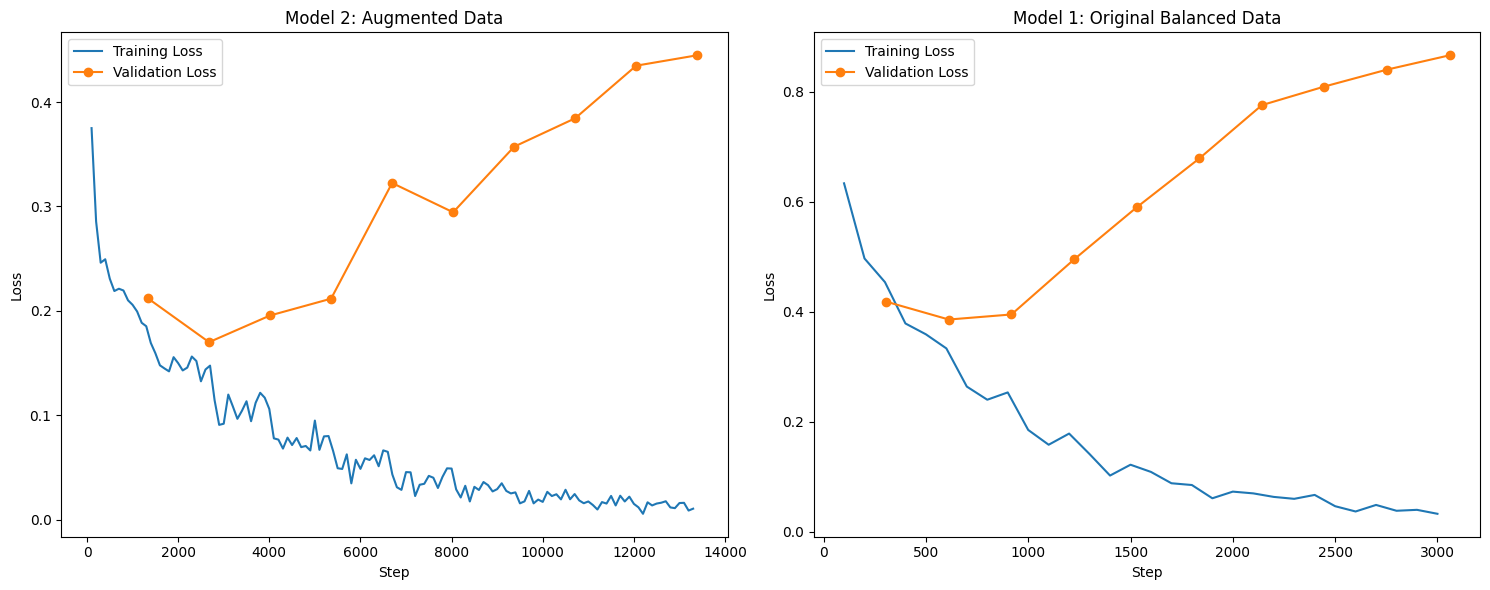

In [57]:
with open('phobert_toxic_result/checkpoint-13390/trainer_state.json', 'r') as f:
    data1 = json.load(f)

history1 = data1['log_history']
train_data1 = []
eval_data1 = []

for entry in history1:
    if 'loss' in entry:
        train_data1.append(entry)
    if 'eval_loss' in entry:
        eval_data1.append(entry)

df_train1 = pd.DataFrame(train_data1)
df_eval1 = pd.DataFrame(eval_data1)

with open('phobert_toxic_result_10k/checkpoint-3060/trainer_state.json', 'r') as f:
    data2 = json.load(f)

history2 = data2['log_history']
train_data2 = []
eval_data2 = []

for entry in history2:
    if 'loss' in entry:
        train_data2.append(entry)
    if 'eval_loss' in entry:
        eval_data2.append(entry)

df_train2 = pd.DataFrame(train_data2)
df_eval2 = pd.DataFrame(eval_data2)

plt.figure(figsize=(15, 6))

# First model
plt.subplot(1, 2, 1)
plt.plot(df_train1['step'], df_train1['loss'], label='Training Loss')
plt.plot(df_eval1['step'], df_eval1['eval_loss'], label='Validation Loss', marker='o')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.title('Model 2: Augmented Data')

# Second model
plt.subplot(1, 2, 2)
plt.plot(df_train2['step'], df_train2['loss'], label='Training Loss')
plt.plot(df_eval2['step'], df_eval2['eval_loss'], label='Validation Loss', marker='o')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.title('Model 1: Original Balanced Data')

plt.tight_layout()
plt.show()

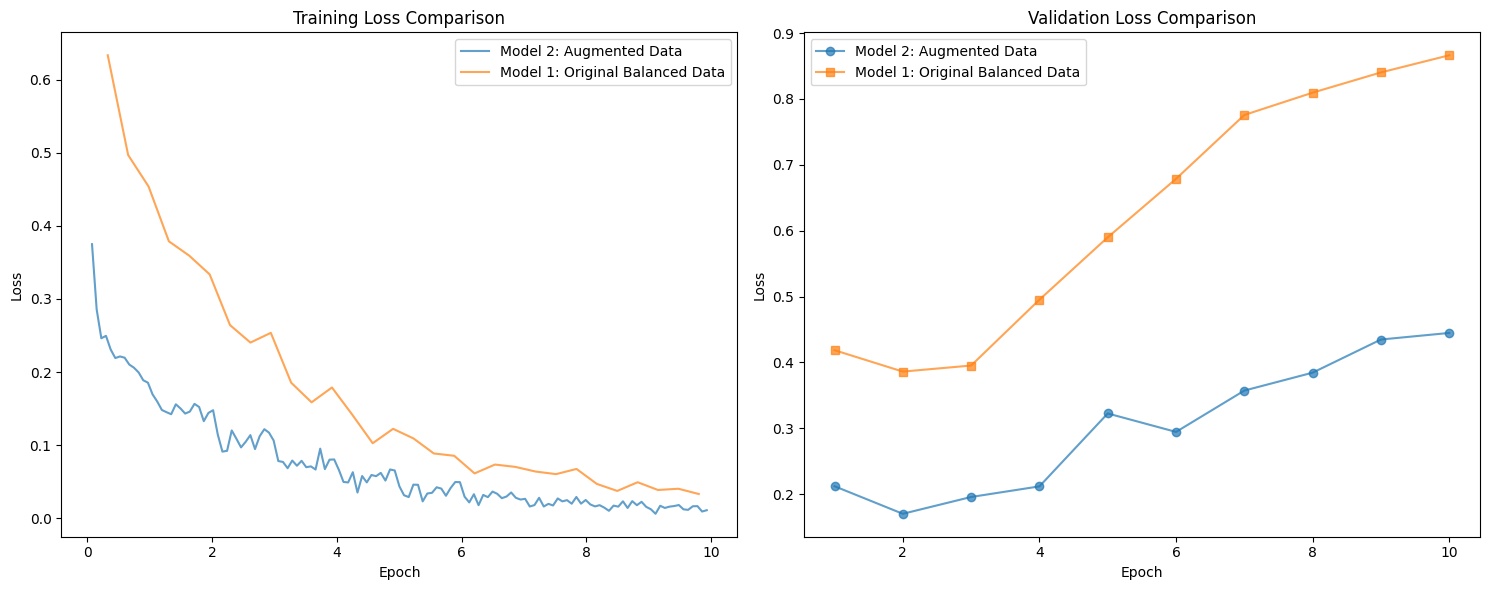

In [58]:
with open('phobert_toxic_result/checkpoint-13390/trainer_state.json', 'r') as f:
    data1 = json.load(f)

history1 = data1['log_history']
train_data1 = []
eval_data1 = []

for entry in history1:
    if 'loss' in entry:
        train_data1.append(entry)
    if 'eval_loss' in entry:
        eval_data1.append(entry)

df_train1 = pd.DataFrame(train_data1)
df_eval1 = pd.DataFrame(eval_data1)

with open('phobert_toxic_result_10k/checkpoint-3060/trainer_state.json', 'r') as f:
    data2 = json.load(f)

history2 = data2['log_history']
train_data2 = []
eval_data2 = []

for entry in history2:
    if 'loss' in entry:
        train_data2.append(entry)
    if 'eval_loss' in entry:
        eval_data2.append(entry)

df_train2 = pd.DataFrame(train_data2)
df_eval2 = pd.DataFrame(eval_data2)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(df_train1['epoch'], df_train1['loss'], label='Model 2: Augmented Data', alpha=0.7)
plt.plot(df_train2['epoch'], df_train2['loss'], label='Model 1: Original Balanced Data', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Comparison')

# Validation Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(df_eval1['epoch'], df_eval1['eval_loss'], label='Model 2: Augmented Data', marker='o', alpha=0.7)
plt.plot(df_eval2['epoch'], df_eval2['eval_loss'], label='Model 1: Original Balanced Data', marker='s', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss Comparison')

plt.tight_layout()
plt.show()

In [ ]:
def predict_toxicity(text, model, tokenizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    inputs = tokenizer(
        text, 
        truncation=True, 
        padding='max_length', 
        max_length=256,
        return_tensors='pt'
    )
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()
        confidence = predictions[0][predicted_class].item()
    
    label = "toxic" if predicted_class == 1 else "non-toxic"
    return {
        'text': text,
        'label': label,
        'confidence': f"{confidence:.2%}"
    }

In [61]:
input_text = "Á à con chó này"
result = predict_toxicity(input_text, model_from_checkpoint, tokenizer_from_checkpoint)

print(f"\ntext: {result['text']}")
print(f"prediction: {result['label']}")
print(f"confidence: {result['confidence']}")

RuntimeError: Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)